# Hierarchical Binomial Model: Rat Tumor Example

https://docs.pymc.io/notebooks/GLM-hierarchical-binominal-model.html

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import pymc3.distributions.transforms as tr
import seaborn as ans
import theano.tensor as tt

import scipy.stats as stats
from scipy.special import gammaln 

print(f'Running on PyMC3 v{pm.__version__}')

Running on PyMC3 v3.9.3


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

The rat tumour example found in chapter 5 of Bayesian Data Analysis 3rd Edition. Readers should already be familliar with the pymc3 api.

## Data from BDA3

- 71 trials, each trial has $n_i$ subjects resulting in $y_i$ cases of positive tumor.

In [8]:
# rat data (BDA3, p. 102)
# fmt: off
y = np.array([
    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
    1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
    5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])
# fmt: on

N = len(n)
print(f'Total {N} trials.')
print(f'In total, R = {sum(y)/sum(n):.2} for {sum(y)} out of {sum(n)}')

Total 71 trials.
In total, R = 0.15 for 267 out of 1739


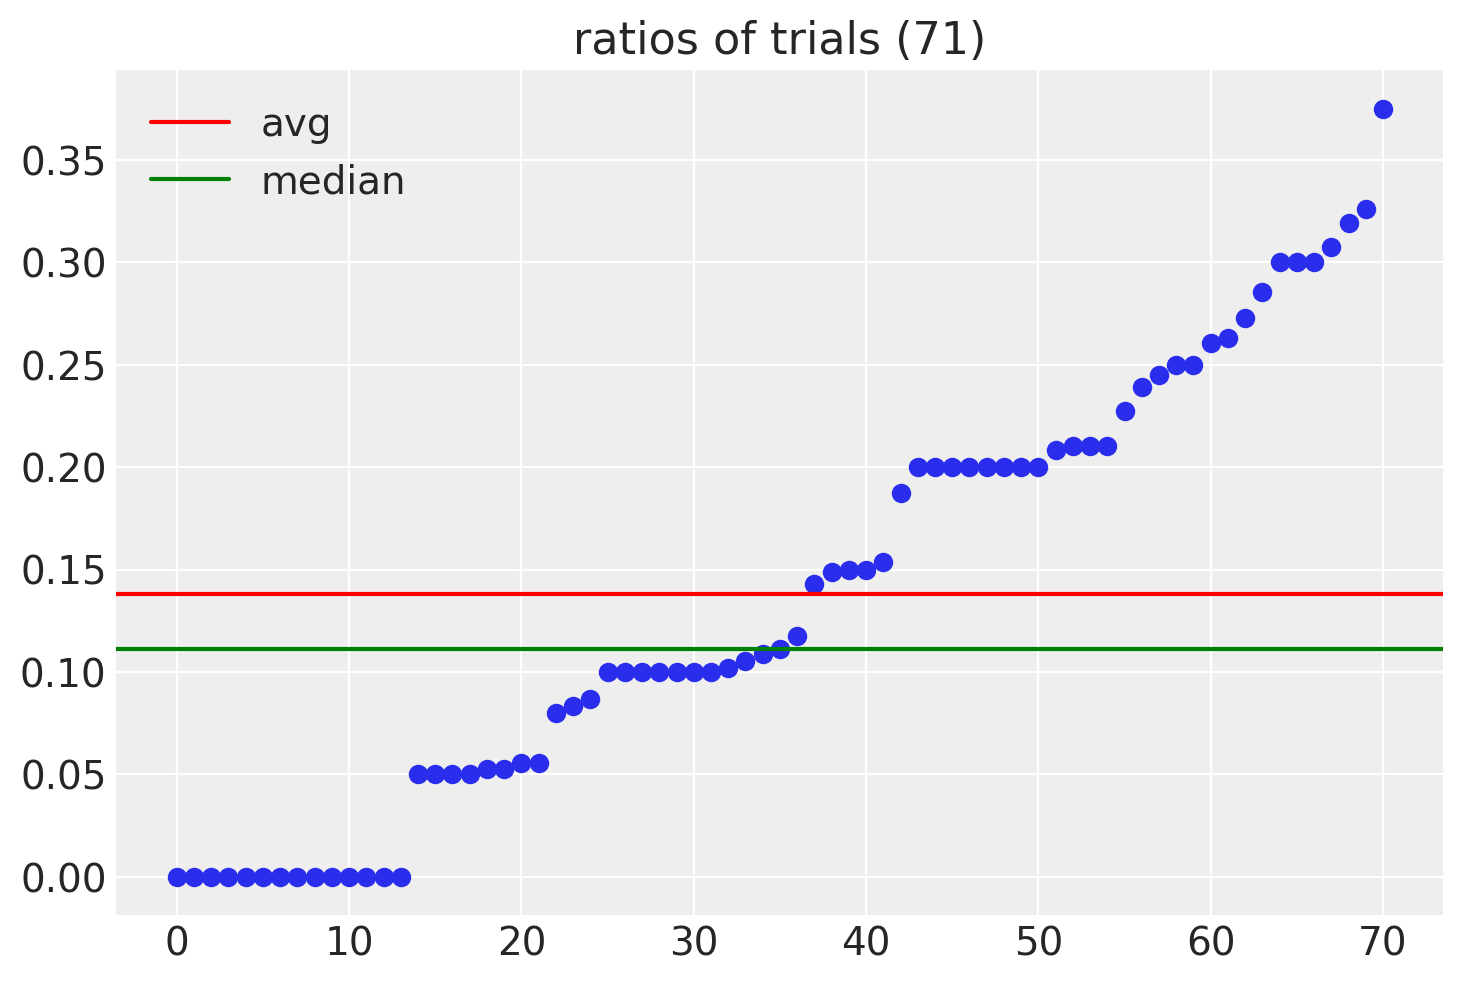

In [20]:
r = y / n
r.sort()
avg = r.mean()
median = np.median(r)

plt.plot(r, 'o')
plt.title(f'ratios of trials ({N})');
plt.axhline(y=avg, c='r', label='avg')
plt.axhline(y=median, c='g', label='median')
plt.legend();

## Beta - Binomial Conjugate Modeling for Each Trial

When each trial is modelled by beta-binomial conjugate pair,
$$
y_i \sim Binomial(n_i, \theta_i) \quad \Leftrightarrow \quad p(y_i | \theta_i) = Binomial(y_i | n_i, \theta_i) \\
\theta_i \sim Beta(\alpha_i, \beta_i) \quad \Leftrightarrow \quad p(\theta_i) = Beta(\theta_i| \alpha_i, \beta_i)
$$
the posterior is given by
$$
    p(\theta_i | y_i) = Beta(\theta_i | \alpha_i + y_i, \beta_i + n_i - y_i) \\
    = \frac{p(y_i|\theta_i) p(\theta_i | \alpha_i, \beta_i)}{ \int   }
$$

Here we do not need to perform integration to obtain the posterior distriubtion.

### Let's see about the case: n=47, y=15
- $\alpha_i$ = $\beta_i$ = 1 for a flat (non-informative) prior

In [4]:
n_i = n[-3]
y_i = y[-3]
print(f'y= {y_i} out of {n_i}: {y_i/n_i:.2}')
ai, bi = 1, 1
ap, bp = ai + y_i, bi + n_i - y_i

y= 15 out of 47: 0.32


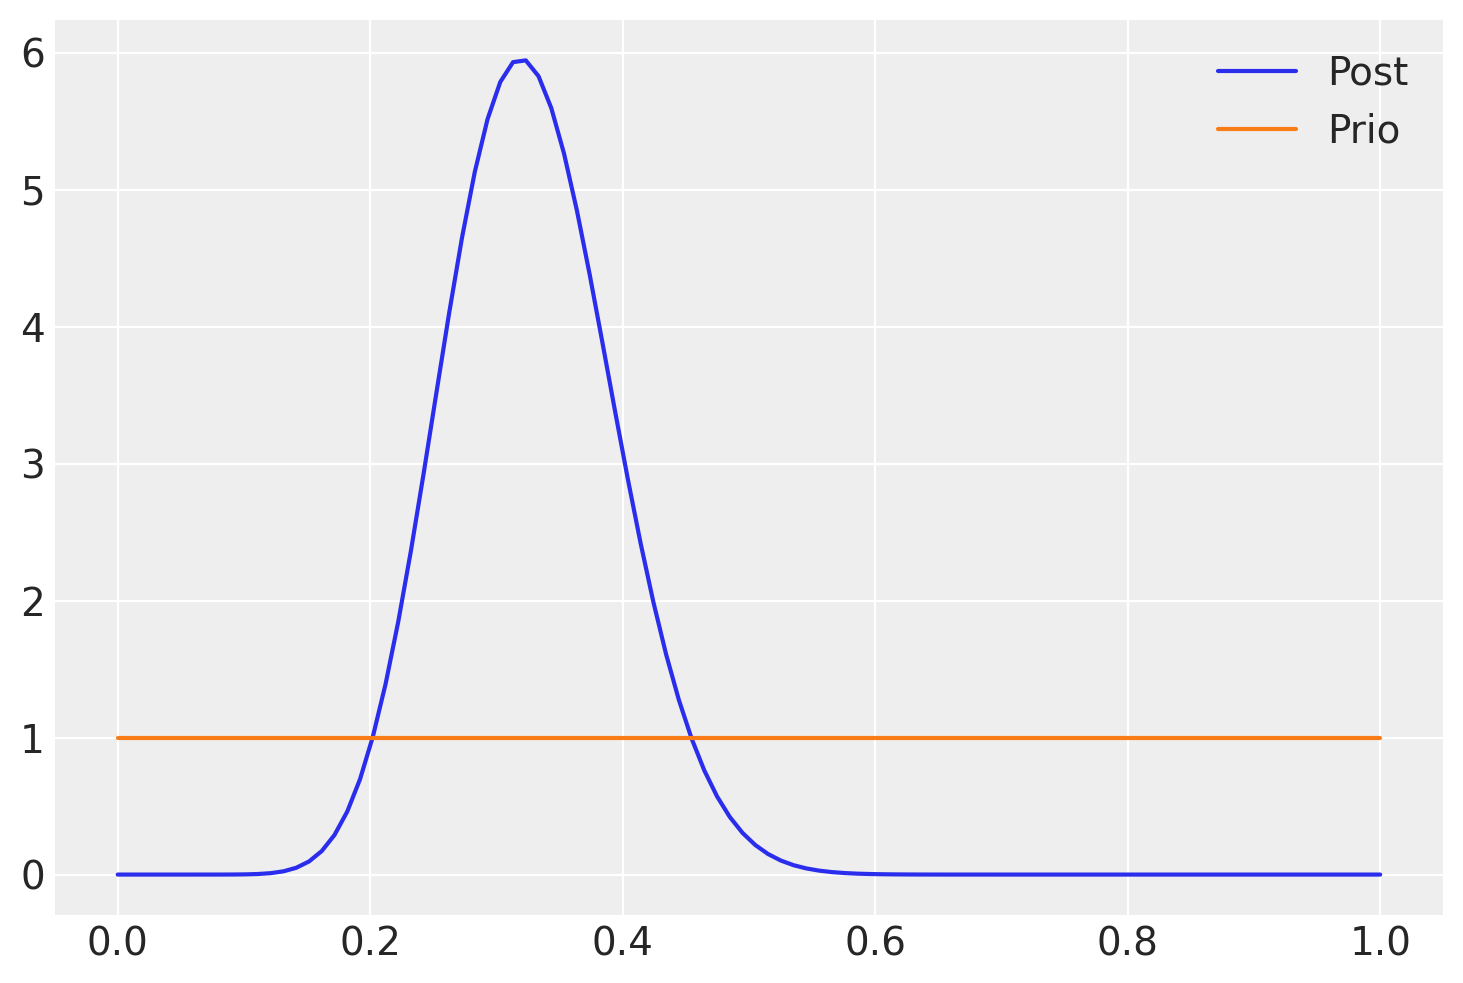

In [5]:
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta(a=ap, b=bp).pdf(x), label='Post');
plt.plot(x, stats.beta(a=ai, b=bi).pdf(x), label='Prio');
plt.legend();

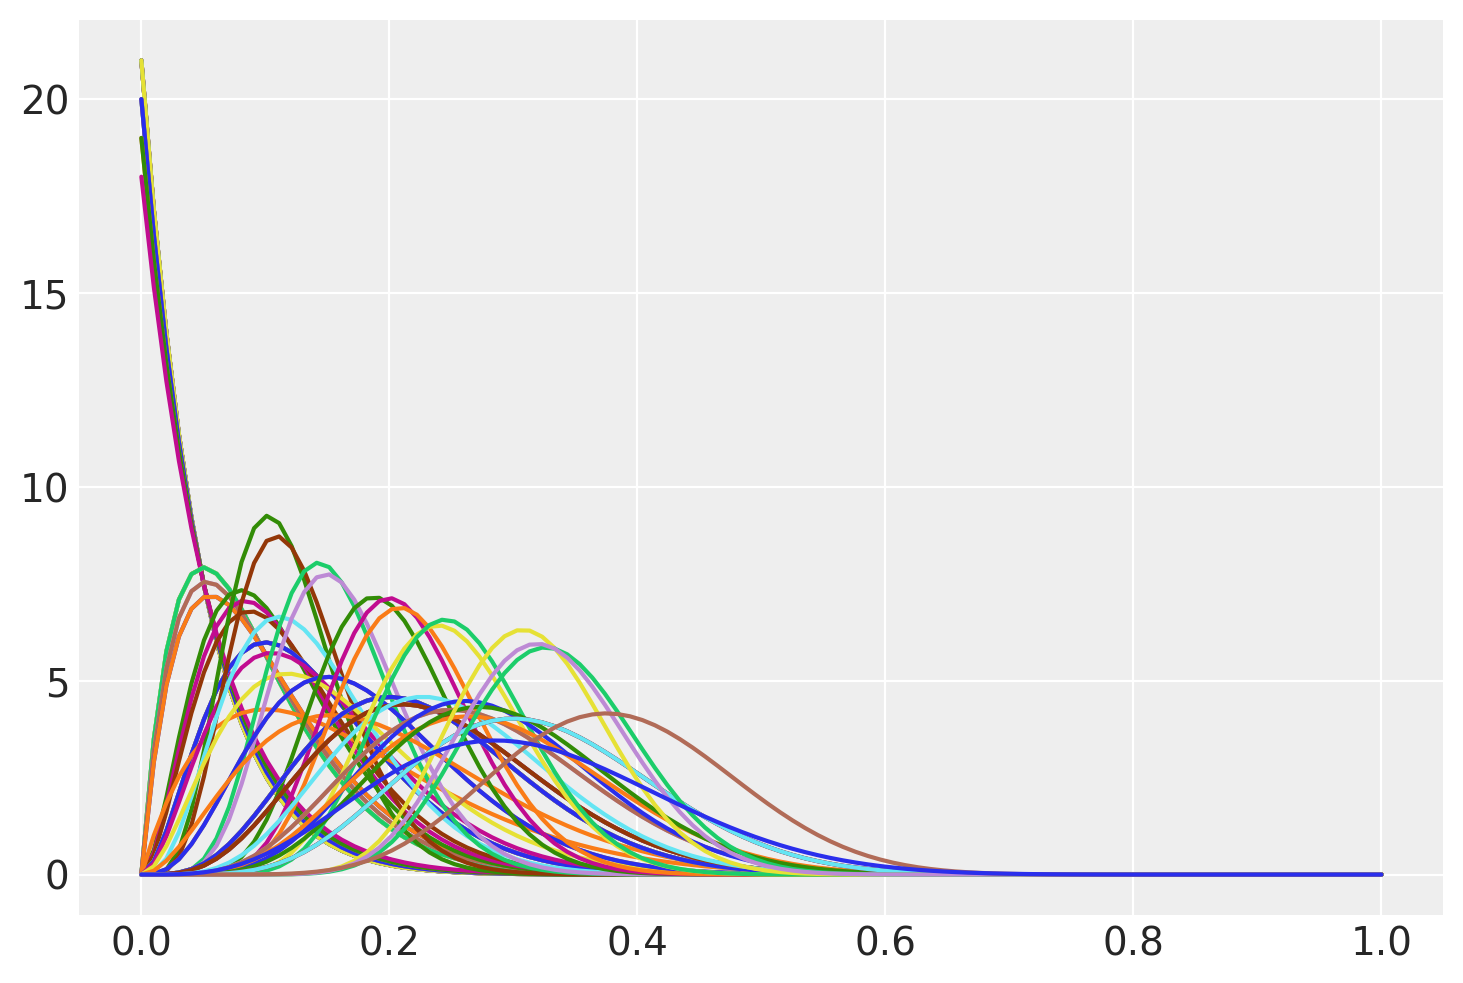

In [6]:
plt.figure()
for yi, ni in zip(y, n):
#     print(f'y= {yi} out of {ni}: {yi/ni:.2}')
    ai, bi = 1, 1
    ap, bp = ai + yi, bi + ni - yi
    plt.plot(x, stats.beta(a=ap, b=bp).pdf(x), label=f'{yi}/{ni}');

## Hierarchical Model